# Parameter estimation: A Bayesian and a frequentist approach

In [63]:
# Authors:
# A. del Rio Chanona - Imperial College (https://www.imperial.ac.uk/people/a.del-rio-chanona)
# H. Wang            - Imperial College London
# D. Zhang           - University of Manchester
# P. Petsagkourakis  - University College London

# To cite please use the publications [1][2][3] at the end of the document.

# Optimisation and Machine Learning for Process Systems Engineering: 
# https://www.imperial.ac.uk/optimisation-and-machine-learning-for-process-engineering/about-us/

# Other codes: https://www.imperial.ac.uk/optimisation-and-machine-learning-for-process-engineering/codes/

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import functools
import operator
import numpy as np
#from scipy.integrate import odeint
import scipy.integrate as scp
import scipy.stats
import math

import sobol_seq
from scipy.optimize import minimize
from numdifftools import Hessian as hess

In [64]:
import pickle
''' Data treatment'''
def save_pkl(item, fname):
    sn = 'tmp/' + fname
    with open(sn, 'wb') as handle:
        pickle.dump(item, handle) #, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'File saved at: {sn}')
    return None
# return None

def load_pkl(fname):
    with open(fname, 'rb') as handle:
        ans = pickle.load(handle)
    print(f'Loaded from: {fname}')
    return ans

# Example model and data generation

Here we present the case study we will be using to illustrate the Bayesian and frequentist approach

## Model



Firstly, we will consider a simple continuous fermentation problem. The states defining the system are simply Biomass, $X$ and Nitrate, $N$ concentrations. This dynamic system can be described as:

$$\frac{\text{d}x}{\text{d}t}=\mu~x~\frac{N}{N+K_N}-\mu_d~x^2$$ 

$$\frac{\text{d}N}{\text{d}t}=-Y_{N/x}~\mu~\frac{N}{N+K_N}x+F_{N_{in}}$$

In this case, the control available to the agent is purely desribed the nitrate inflow rate $$F_{N_{in}}\in[0,7]$$

This means the nitrate inflow rate can take any value in the range $[0,7] mg/h$ (please note units, $X$ $g/L$ and $N$ $mg/L$). For the purposes of this notebook, we have fixed $F_{N_{in}}=4.5$ as this is a model identification excercise.

In [65]:
#################
# Dynamic Model #
#################

class ModelIntegration:
    '''
    This files integrates the model.
    model: this is were the model should be changed 
    '''
    
    # --- initializing model --- #
    def __init__(self, parameters):
        
        # Object variable definitions
        self.parameters = parameters
        
    # --- dynamic model definition --- #    
    def model(self, t, state):
        # internal definitions
        params = self.parameters
        
        # define controls here
        FCn    = 4.5
        
        # state vector
        Cx  = state[0]
        Cn  = state[1]
        
        # parameters
        u_m  = params['u_m']; K_N  = params['K_N'];
        u_d  = params['u_d']; Y_nx = params['Y_nx'];
        
        # algebraic equations
        
        # variable rate equations
        dev_Cx  = u_m * Cx * Cn/(Cn+K_N) - u_d*Cx**2
        dev_Cn  = - Y_nx * u_m * Cx * Cn/(Cn+K_N) + FCn
        
        return np.array([dev_Cx, dev_Cn],dtype='float64')
    
    # --- simulation --- #
    def simulation(self, steps, tf, x0):
        '''
        simulate for a number of steps to collect data, and a final time
        '''

        # external definitions
        self.x0, self.tf = x0, tf

        # internal definitions
        model = self.model
        dt    = tf/(steps)
        
        # compile state trajectories
        xt = np.zeros((x0.shape[0],steps+1))
        tt = np.zeros((steps+1))
        
        # initialize simulation
        current_state = x0
        xt[:,0]       = current_state
        tt[0]         = 0.
        
        # simulation
        for s in range(steps):
            ode           = scp.ode(model)                  # define ode
            ode.set_integrator('lsoda', nsteps=3000)        # define integrator
            ode.set_initial_value(current_state, dt)        # set initial value
            current_state = list(ode.integrate(ode.t + dt)) # integrate system
            xt[:,s+1]     = current_state                   # add current state
            tt[s+1]       = (s+1)*dt
        
        return xt, tt            

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


xobs.shape =  (2, 11)
tt.shape =  (11,)


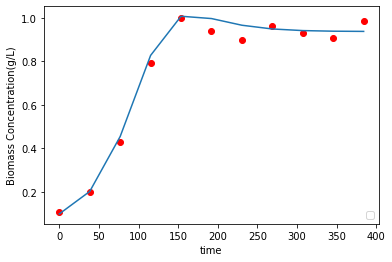

In [66]:
####################################################
# Creating data from existing model and parameters #
####################################################

p  = {'u_m' : 0.0923*0.62, 'K_N' : 393.10, 'u_d' : 0.01, 'Y_nx' : 504.49}


tf       = 16.*24.
steps_   = 10
x0       = np.array([0.1,150.0])

m            = ModelIntegration(p)
xt, tt       = m.simulation(steps_, tf, x0) 
random_noise = np.random.multivariate_normal(np.array([0,0]), np.diag(np.ones(2)),steps_+1)
xobs         = xt*(1+random_noise.T*0.05)

print('xobs.shape = ', xobs.shape)
print('tt.shape = ', tt.shape)

import matplotlib.pyplot as plt

plt.plot(tt,xobs[0]/np.max(xobs[0]), 'o',color = 'red')
plt.plot(tt,xt[0]/np.max(xobs[0]), '-')
plt.ylabel('Biomass Concentration(g/L)')

plt.xlabel('time')
plt.legend(loc="lower right")
matplotlib.rcParams.update({'font.size': 12})
plt.savefig("high f.jpg")
plt.show()



# Frequentist parameter estimation

The frequentist approach to statistics is the most widely used, and hence is sometimes called the orthodox approach or classical approach, and (loosely speaking), its goal is to compute a **point estimate** of some unknown parameters $\theta$ in a model.

Point estimation refers to computing a single *best guess* of some quantity of interest from data. The quantity could be a parameter in a parametric model (such as the mean of a Gaussian), or a regression function (such as the parameters in our models), or a prediction of a future value of some random variable. We assume there is some “true” value for this quantity, which is fixed.

**Maximum likelihood estimation** is a point estimate that computes the parameters that make the data as likely as possible. Given a $\textbf{Likelihood}$ function $\mathcal{L}(d|\theta, \mathcal{M})$ which gives the probability of the $\textbf{data}$ given our parameters $\theta$ and model $\mathcal{M}$, the maximum likelihood estimate would be calculated by:

$$\theta^*_{mle}=\text{argmax}_{\theta} \mathcal{L}(d|\theta, \mathcal{M})$$

Maximum likelihood estimation (MLE) has many ideal characteristics in estimation: sufficiency (containing complete information about the parameter of interest in its MLE estimator); consistency (the true parameter value that generated the data is approached asymptotically, e.g. when the data comprises a sufficiently large sample); efficiency (lowest-possible variance of parameter estimated achieved asymptotically); and parameterization invariance (same MLE solution obtained independent of the parametrisation method used). The way a MLE comes into play in models is as follows. Consider a generic dynamic model:

$$f_{\mathcal{M}}(\dot{x},x,y,\theta)=0$$

where $x$ are differential variables, $y$ are algebraic variables, and $\theta$ are parameters.

If it is assumed that the probability density function of the residual $R(\theta)$ is Gaussian, the probability density function for one measurement is the following:

$$p\left(\hat{d}_i\mid \mathcal{M},\theta\right)=\frac{1}{\sqrt{2\pi\sigma}}\exp\left[-\frac{1}{2}\left(\frac{R(\theta)}{\sigma}\right)^{2}\right]$$

where $\sigma$ is the standard deviation. Then, taking the maximum likelihood:

$$\max_{\theta}~p\left(\hat{d}_i\mid \mathcal{M},\theta\right)=\max_{\theta}~\frac{1}{\sqrt{2\pi\sigma}}\exp\left[-\frac{1}{2}\left(\frac{R(\theta)}{\sigma}\right)^{2}\right]$$

Due to the property of monotonicity of the logarithm (which is important for optimization), we can take the logarithm which yields the *log-likelihood* (making numerical optimization easier), we firther substitute the maximization by the minus minimization, which results in: 

$$\max_{\theta}~\frac{1}{2}\ln\left(2\pi\right)+\ln\left(\sigma\right)+\frac{1}{2}\left(\frac{R(\theta)}{\sigma}\right)^{2}$$

If the case of multiple measurements, we have:

$$\max_{\theta}~\prod_{i}p\left(\hat{d}_i\mid \mathcal{M},\theta\right)=\max_{\theta}~\prod_{i}\frac{1}{\sqrt{2\pi\sigma}}\exp\left[-\frac{1}{2}\left(\frac{R_i(\theta)}{\sigma}\right)^{2}\right]$$	
$$=\min_{\theta}~\underset{i}{\sum}\frac{1}{2}\ln\left(2\pi\right)+\frac{1}{2}\ln\left(\sigma\right)+\frac{1}{2}\left(\frac{R_i(\theta)}{\sigma}\right)^{2}	$$

The above assumes the following is true:

*   Prior is uniform between upper and lower bounds
*   Only the maximum is considered instead of the expected
*   Residuals are normally distributed
*   Data measurements are independent

Furthermore, if a different (given) variance for each measurement is assumed, we obtain the weighted sum of squares residuals for $N$ data points:

$$\min_{\theta}\quad\underset{i=1}{\sum^{N}}\left(\frac{\hat{d}_{i}-d_{i}}{\sigma_{i}}\right)^{2}$$

In what follows, we show how this can be computed using standsrd tools from *numpy* and *scipy*



## Negative Log Likelihood function

In [67]:
Qmat = np.diag(np.std(xobs, axis=1)**2)
Qmat = np.linalg.inv(Qmat)
print('Qmat = ',Qmat)

def NLL(theta, p=p, x0=x0, steps_=steps_, tf=tf, xobs=xobs, Qmat=Qmat):
    theta_dic = {key1:theta[indx] for indx,key1 in enumerate(p)}  
    m         = ModelIntegration(theta_dic)
    xt, _     = m.simulation(steps_, tf, x0) 
    x_error   = (xobs-xt)
    nll       = sum(x_error.T[i]@Qmat@x_error.T[i] for i in range(x_error.shape[1]))

    return nll

p_num = [p[key1] for key1 in p]
print('negative log likelihood base scenario is:',NLL(p_num))
print('NLL', NLL)

Qmat =  [[9.89888529e+00 0.00000000e+00]
 [0.00000000e+00 1.52177751e-04]]
negative log likelihood base scenario is: 0.19269502005515224
NLL <function NLL at 0x0000023B71020790>


# Frequentist estimation of parameters

## Parameters estimation of dynamic systems

$$\min_{x(\cdot),\theta\in\Theta} \quad \sum_i^{n_d} \sum_j^{n_x} ( x_j(t_i)-\hat{x}_j(t_i) )^TQ^{-1} ( x_j(t_i)-\hat{x}_j(t_i) ) $$
subject to:
$$\dot{x}(t)=f(x(t),\theta) \quad t\in [0,T]$$
$$g(x(t),\theta) \leq 0 \quad t\in [0,T]$$
$$h(x(t),\theta)=0 \quad t\in [0,T]$$
$$x(0)=x_0$$

where $Q^{-1}$ is a positive-definite weighting matrix, $x\in \mathbb{R}^{n_x}$ are the states predicted by the model, $\hat{x}\in \mathbb{R}^{n_x}$ are the measurements of the states, $u\in \mathbb{R}^{n_u}$ are the controls, $f:\mathbb{R}^{n_x} \times \mathbb{R}^{n_u} \rightarrow \mathbb{R}^{n_x}$ describe the differential equations, $g:\mathbb{R}^{n_x} \times \mathbb{R}^{n_u} \rightarrow \mathbb{R}^{n_g}$ are path constraints, and $h:\mathbb{R}^{n_x} \times \mathbb{R}^{n_u} \rightarrow \mathbb{R}^{n_h}$ are equality constraints, if $h$ are present, the above is a differential-algebraic equation (DAE) system.

In [68]:
# -- bounds on paramter estimates -- #

lb = [p[key]*0.1 for key in p]
ub = [p[key]*10. for key in p]
lb              = np.array(lb)    # lb on parameters
ub              = np.array(ub)    # ub on parameters
bounds          = np.hstack((lb.reshape(len(lb),1), ub.reshape(len(lb),1)))


multi_start     = 30                       # multistart on hyperparameter optimization
multi_startvec  = sobol_seq.i4_sobol_generate(len(lb),multi_start)

options  = {'disp':True,'maxiter':10000} # solver options
localsol = [0.]*multi_start               # values for multistart
localval = np.zeros((multi_start))        # variables for multistart

# --- multistart loop --- # 
for j in range(multi_start):
    print('multi start parameter optimization iteration = ',j,)
    u_init    = lb + (ub-lb)*multi_startvec[j,:]
    # --- hyper-parameter optimization --- #
    res = minimize(NLL, u_init, options=options, bounds=bounds, method='SLSQP', tol=1e-10)
    # method='SLSQP'
    localsol[j] = res.x
    localval[j] = res.fun

# --- choosing best solution --- #
minindex = np.argmin(localval)
u_opt    = localsol[minindex]
# print(u_opt)

multi start parameter optimization iteration =  0


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14888727868350543
            Iterations: 94
            Function evaluations: 511
            Gradient evaluations: 92
multi start parameter optimization iteration =  1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1488872781221358
            Iterations: 70
            Function evaluations: 372
            Gradient evaluations: 67
multi start parameter optimization iteration =  2
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5421948317911613
            Iterations: 48
            Function evaluations: 260
            Gradient evaluations: 45
multi start parameter optimization iteration =  3
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1488872795035082
            Iterations: 68
            Function evaluations: 358
            Gradient evaluations: 65
multi

## Evaluating frequentist solution

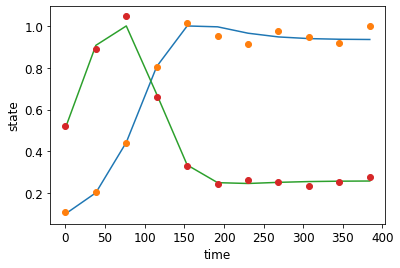

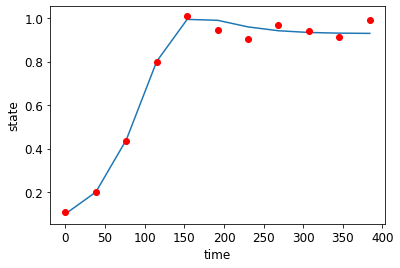

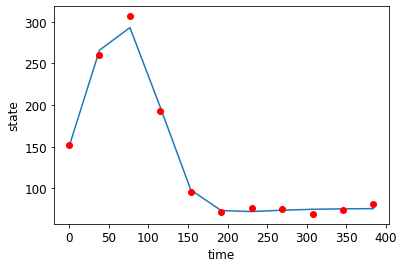

In [69]:
popt      = u_opt
theta_opt = {key1:popt[indx] for indx,key1 in enumerate(p)}
m         = ModelIntegration(theta_opt)
xt, tt    = m.simulation(steps_, tf, x0)

# --- plot results --- #

import matplotlib.pyplot as plt
for i in range(xt.shape[0]):
    plt.plot(tt,xt[i,:]/np.max(xt[i,:]))
    plt.plot(tt,xobs[i,:]/np.max(xt[i,:]), 'o')
plt.ylabel('state')
plt.xlabel('time')
plt.show()

for i in range(xt.shape[0]):
    plt.plot(tt,xt[i,:])
    plt.plot(tt,xobs[i,:], 'ro')
    plt.ylabel('state')
    plt.xlabel('time')
    plt.show()

### Frequentist confidence intervals

#### Derivation of confidence ellipsoids

Let us assume that we have found a solution to the system:

$${\bf d}={\bf X}{\bf \theta}+\epsilon$$

where ${\bf d} \in \mathbb{R}^{n_d}$ is a vector of observed values of the dependent variable, ${\bf X}\in \mathbb{R}^{n_d \times n_\theta}$ is a matrix of observed values of independent variables (which can represent a physical model) which is assumed to be known exactly. ${\bf \theta}$ is a column vector containing the $n_\theta$ parameters which are to be estimated, and $\epsilon \in \mathbb{R}^{n_d}$ is a vector of errors which are assumed to be independently distributed with normal distributions with zero mean and each having the same unknown variance $\sigma^{2}$. We therefore wish to make an estimate $\hat{\theta}$ by minimizing the residual:

$$\epsilon={\bf X}\hat{\theta}-d$$

In least squares estimation, the sum of the squares of the elements
of the residual vector is minimized. This minimization is
equivalent to:

$${\bf X}^{\dagger}{\bf d}=\hat{\theta}$$

where ${\bf X}^{\dagger}$ is the pseudoinverse of ${\bf X}$.

Now, we know that $\hat{\theta}$ will be a random variable (given the particular error we have for the measurements when we sample our data). Furthermore, for each parameter $\theta_i$ we know the distribution of this random variable to be:

$$\frac{\hat{\theta}_i-\theta_i}{SE[\hat{\theta}_i]} \sim \mathcal{N}(0,1)$$

where $SE$ refers to the *standard error* (i.e. the standard deviation of the sampling distribution for the sample mean - notice the above is a simple standarization).

Now, assume we have a second parameter $\theta_j$ which is uncorrelated with $\theta_i$, then we would have:

$$\left( \frac{\hat{\theta}_i-\theta_i}{SE[\hat{\theta}_i]} \right)^2 + \left( \frac{\hat{\theta}_j-\theta_j}{SE[\hat{\theta}_j]} \right)^2 \sim \chi^2_2  $$

**Remember**: when $z_1,\dots z_{n_s}$ are independent $\mathcal{N}(0,1)$ variables, then $\sum_iz^2_i \sim \chi^2_{n_\theta}$.

Therefore, a simultaneous $1−\alpha$ confidence region for $(\theta_i,\theta_j)$ would be the region where

$$\left( \frac{\hat{\theta}_i-\theta_i}{SE[\hat{\theta}_i]} \right)^2 + \left( \frac{\hat{\theta}_j-\theta_j}{SE[\hat{\theta}_j]} \right)^2 \leq \chi^2_2(1−\alpha)  $$

**Note**: the above region is an ellipse with axes parallel to the coordinate axis (as there is no correlation), with axes of size $2SE[\hat{\theta}_i]\chi^2_2(1−\alpha)$ and $2SE[\hat{\theta}_j]\chi^2_2(1−\alpha)$

If instead of 2 we had $n_\theta$ uncorrelated parameters $(\theta_1,\dots,\theta_{n_\theta})$  the confidence region would be:

$$\sum_{i=1}^{n_\theta} \left( \frac{\hat{\theta}_i-\theta_i}{SE[\hat{\theta}_i]} \right)^2  \leq \chi^2_{n_\theta}(1−\alpha)$$

Usually, the different parameter estimates are correlated with each
other, so something different must be taken into consideration. If we write $\overline{\theta}=[\theta_1,\dots,\theta_{n_\theta}]$ for the vector of
coefficients we’re interested in, and $V_\theta$ for its variance-covariance matrix, then the confidence region is the set of all $\overline{\theta}$ is:

$$(\overline{\hat{\theta}} - \overline{\theta})^T V^{-1}_\theta (\overline{\hat{\theta}} - \overline{\theta}) \leq \chi^2_{n_\theta}(1−\alpha) $$

This, too, is an ellipsoid, only now the axes point in the directions given by the eigenvectors of $V_\theta$, and the length along each axis is proportional to the square root of the corresponding eigenvalue.

Note that the $F$ and $\chi^2$ statistics are really the same thing in that, after a normalization ($(\text{numerator degrees of freedom})*F=\chi^2$), chi-squared is the limiting distribution of the F as the denominator degrees of freedom goes to infinity. This translates into the fact that is we assume an umbiased estimate of $V_\theta$, then we can replace $\chi^2_{n_\theta}(1−\alpha)$ with $n_\theta F^\alpha_{n_\theta,n-n_\theta}$


#### Computing the Hessian

To compute confidence intervals, we wish to obtain the covariance matrix of the maximum likelihood estimate. We know that the Fisher information matrix is probably the best estimate for the covariance matrix, and at the same time, under some regularity conditions where the interchange of differentiation and integratio is valid the FIM is equivalent to the expected value of the Hessian matrix at the optimal solution. Therefore, we approximate the covariance matrix by the Hessian matrix.

In [70]:
#########################################
# Central second order finite differences
#########################################

def Second_diff_fxx(f, x):
    '''
    Calculating the Hessian via finite differences: https://en.wikipedia.org/wiki/Finite_difference
    '''
    Delta = 1e2*np.sqrt(np.finfo(float).eps) #step-size is taken as function of machine precision
    n     = np.shape(x)[0]
    x     = x.reshape((n,1))
    Hxx   = np.zeros((n,n))
    for j in range(n):
        # compute Fxx (diagonal elements)
        x_d_f    = np.copy(x)
        x_d_b    = np.copy(x)
        x_d_f[j] = x_d_f[j] + Delta
        x_d_b[j] = x_d_b[j] - Delta

        Hxx[j,j] = (f(x_d_f.flatten()) -2*f(x.flatten()) + f(x_d_b.flatten()))/Delta**2

        for i in range(j+1,n):
            # compute Fxy (off-diagonal elements)
            # Fxy
            x_d_fxfy    = np.copy(x_d_f)
            x_d_fxfy[i] = x_d_fxfy[i] + Delta
            x_d_fxby    = np.copy(x_d_f)
            x_d_fxby[i] = x_d_fxby[i] - Delta
            x_d_bxfy    = np.copy(x_d_b)
            x_d_bxfy[i] = x_d_bxfy[i] + Delta
            x_d_bxby    = np.copy(x_d_b)
            x_d_bxby[i] = x_d_bxby[i] - Delta
            Hxx[j,i]    = (f(x_d_fxfy.flatten()) - f(x_d_fxby.flatten()) - 
                           f(x_d_bxfy.flatten()) + f(x_d_bxby.flatten()))/(4*Delta**2)
            Hxx[i,j]    = Hxx[j,i]

    return Hxx

In [71]:
param_name = ["$u_{m}$","$K_{N}$","$u_{d}$","$Y_{Nx}$"]
p  = {'u_m' : 0.0923*0.62, 'K_N' : 393.10, 'u_d' : 0.01, 'Y_nx' : 504.49}

#### Computing gradients

Another way of computing the Hessian is to apply the gradient twice.

In [72]:
#########################################
# 4-point first order finite differences
#########################################

def compute_derivative(f, X):
    size  = len(X)
    if np.array([f(X)]).ndim==1:
      sizey = 1
    else:
      sizey = size
    dmdx  = np.zeros([sizey, size])

    v = np.eye(size)
    h = 1e-7
    for i in range(sizey):
        for j in range(size):
            X_left1  = X.copy()
            X_left2  = X.copy()
            X_right1 = X.copy()
            X_right2 = X.copy()

            X_left1  += h*v[j,:]
            X_left2  += 2*h*v[j,:]
            X_right1 += -h * v[j,:]
            X_right2 += -2*h * v[j,:]

            dmdx[i, j] =  (-f(X_left2).reshape((1,-1,))[0, i] 
                            +8*f(X_left1).reshape((1,-1,))[0, i]
                            -8*f(X_right1).reshape((1,-1,))[0, i]
                            + f(X_right2).reshape((1,-1,))[0, i])/12/h
    return dmdx


In [73]:
import functools
df = functools.partial(compute_derivative, NLL)

Hpp_1 = Second_diff_fxx(NLL, u_opt)                   # computing hessian option 1
Hpp   = compute_derivative(df, u_opt.reshape((-1,)))  # computing hessian option 2
print('optimum = ', NLL(u_opt))
print('Eigenvalues ', np.linalg.eigvals(Hpp) )
print('PSD Hpp? ', np.all(np.linalg.eigvals(Hpp_1) >= 0))

if np.any(np.linalg.eigvals(Hpp_1) <= 0):
    print('Optimzation is solved at saddle point, unable to obatain confidence ellipse')
else:
    print('Able to obatin confidence ellipse')



optimum =  0.1488872781221358
Eigenvalues  [ 3.41027623e+05  6.37453530e+04  6.56761465e-01 -2.76008928e-01]
PSD Hpp?  True
Able to obatin confidence ellipse


In [74]:
inv_hess_mat = np.linalg.inv(Hpp)

In [75]:
from scipy.stats import chi2
dof = 2  # Degrees of freedom for 2D data
chi2_val = chi2.ppf(1 - 0.05, dof)

In [76]:
big_cov =inv_hess_mat

all_cov = []


for i in range (len(param_name)-1):
    each_cov = np.zeros([2,2])
    for j in range(i+1, len(param_name)):
        # print('i,j',i,j)
        each_cov[0][0] = big_cov[i][i]
        each_cov[0][1] = big_cov[i][j]
        each_cov[1][0] = big_cov[j][i]
        each_cov[1][1] = big_cov[j][j]
        all_cov.append(each_cov.copy())


In [77]:
def eigsorted(cov):
    vals, vecs = np.linalg.eig(cov)
    idx_lmb_min = list(abs(vals)).index(min(list(abs(vals))))
    idx_lmb_max = list(abs(vals)).index(max(list(abs(vals))))
    eigval_max = abs(vals[idx_lmb_max])
    eigval_min = abs(vals[idx_lmb_min])
    v1x, v1y = vecs[0, idx_lmb_max], vecs[1, idx_lmb_max]
    return eigval_max,eigval_min,v1x,v1y
from matplotlib.patches import Ellipse

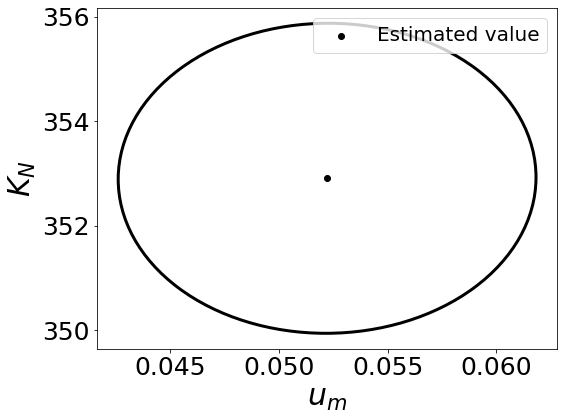

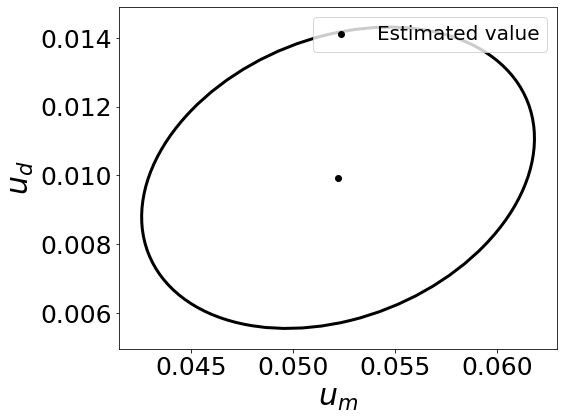

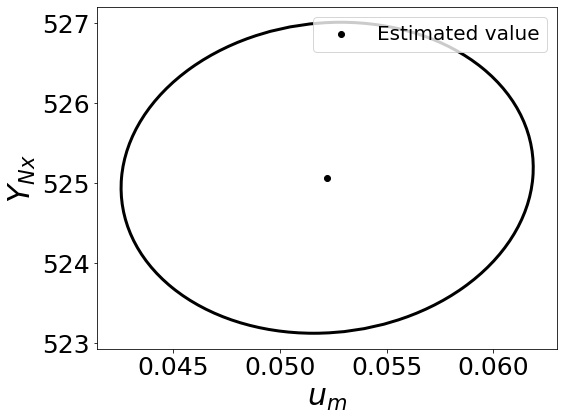

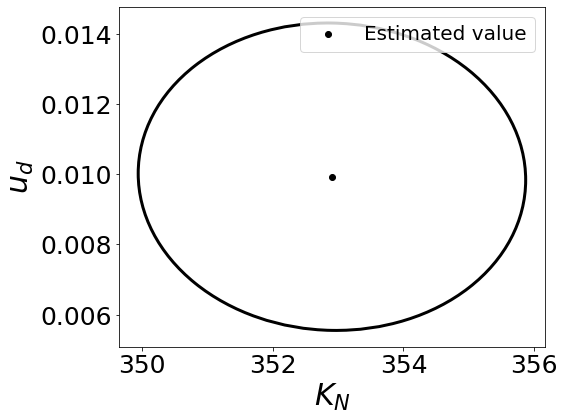

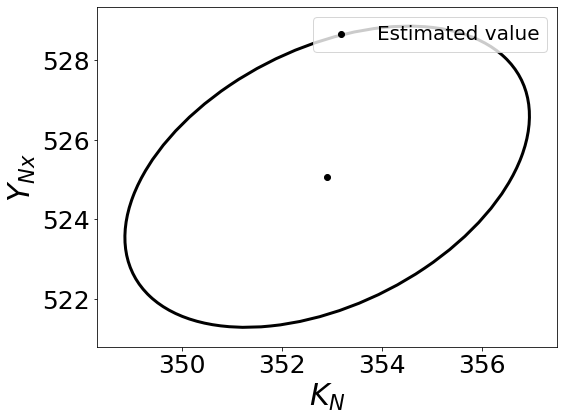

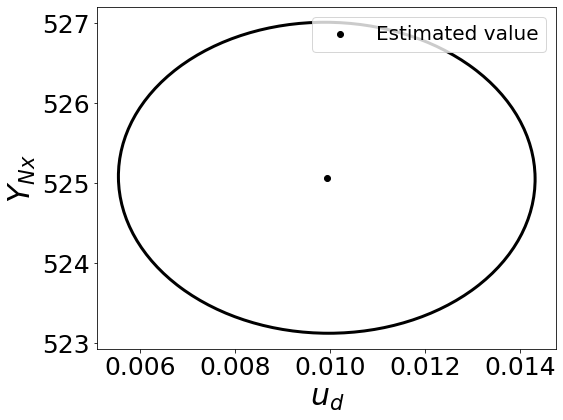

In [78]:
z = 0
for i in range (len(param_name)-1):

    for j in range(i+1, len(param_name)):
        scale = chi2_val
        test = all_cov[z]
        eigval_max,eigval_min,v1x,v1y = eigsorted(test)
        theta = np.rad2deg(np.arctan(v1y / v1x))
        w = 2 * np.sqrt(scale * eigval_max)
        h = 2 * np.sqrt(scale * eigval_min)
        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(8,6)
        ell = Ellipse(xy=(popt[i],popt[j]),
                    width=w, height=h,
                    angle=theta, color='black',linewidth=3)
        plt.scatter(popt[i],popt[j],color='black',label = 'Estimated value')
        # plt.scatter(p_true[x1],p_true[x2],color='red',marker='v',label = 'True value')
        ax.tick_params(axis='both', which='major', labelsize=25)
        ax.set_xlabel(param_name[i], fontsize=30)
        ax.set_ylabel(param_name[j], fontsize=30)
        plt.legend(fontsize=20)

        ell.set_facecolor('none')
        ax.add_patch(ell)

        fig.tight_layout()

        plt.savefig(param_name[i]+param_name[j]+'v1.svg')
        z+=1


# Bayesian estimation of paratemers and confidence regions

The Bayesian paradigm treats the parameters as random variables and
quantifies parametric uncertainty using Bayes' rule:

$$p(\theta|d,\mathcal{M},I)=\frac{\mathcal{L}(d|\theta,\mathcal{M})\pi(\theta|\mathcal{M},I)}{Z(d|\mathcal{M},I)}$$

where:

* $d$: Observational data.
* $\mathcal{M}$: A model that describes our data. This can more generally be thougout of as a hypothesis $\mathcal{H}$. 
* $\theta$: A vector of parameters that describe the model which quantifies the model, for example, an unknown amplitude and/or frequency, noise mean, noise variance etc...
* $I$: "Prior" information. This is $\textit{a priori}$ knowledge about our expectations for the model before we learn from our data. For instance, we might give equal odds to their being a signal or noise.

The expressions in Bayes's rule are:

* $p(\theta | d, \mathcal{M},I)$ : $\textbf{Posterior Probability}$ of the parameters $\theta$. Posterior refers to $\textit{a postiori}$, i.e., what we know about $\theta$ after we analyze the data $d$.
* $\pi(\theta| \mathcal{M}, I)$: $\textbf{Prior Probability}$ of the parameters $\theta$. Prior refers to $\textit{a priori}$, i.e., what we think we know about $\theta$ before we analyze our data.
* $\mathcal{L}(d|\theta, \mathcal{M})$: $\textbf{Likelihood}$ of the data. This is the probability of the $\textbf{data}$ given our parameters $\theta$ and model $\mathcal{M}$.
* $Z(d|\mathcal{M}, I)$: $\textbf{Evidence}\,\, (\text{Marginal Likelihood})$. This is the probability of the data, given a particular hypotheses, such as our model $\mathcal{M}$

Notice that:

$$p(\theta|d,\mathcal{M},I)=\frac{\mathcal{L}(d|\theta,\mathcal{M})\pi(\theta|\mathcal{M},I)}{Z(d|\mathcal{M},I)} = \frac{p(\theta,d|\mathcal{M},I)}{Z(d|\mathcal{M},I)} = \frac{p(\theta,d|\mathcal{M},I)}{\int p(\theta,d|\mathcal{M},I) d\theta }\propto p(\theta,d|\mathcal{M},I)$$

Notice that $\int p(\theta,d|\mathcal{M},I) d\theta =Z(d|\mathcal{M},I)$ is only a constant, given that we marginilize (integrate out) the parameters and the data $d$ is always the same.

## Specifying components of our model

The Bayesian paradigm assumes that the parameters $\theta=\{u_m, K_N, u_d, Y_{nx}\}$ are random variables themselves. We wish to compute their posterior distribution $p(\theta | d, \mathcal{M},I)$ taking into account the data $d$, the model (or hypothesis) $\mathcal{M}$ and "prior" information.

The most difficult part of computing the posterior $p(\theta | d, \mathcal{M},I)$ is obtaining the marginilized term $Z(d|\mathcal{M},I)$, which is inconvenient to obtain directly. Therefore, we will only aim to compute $p(\theta,d|\mathcal{M},I) \propto p(\theta |d, \mathcal{M},I)$. 

At this point, a question becomes apparent. Is $p(\theta,d|\mathcal{M},I)$ really useful if what we really want is the posterior? Because we want to compute the probability [density] distribution $p(\theta | d, \mathcal{M},I)$, having $p(\theta,d|\mathcal{M},I)$ instead is not a big problem, given that we are still able to determine the shape and relative values of the parameter posterior distributions. Therefore, we will focus on obtaining $p(\theta,d|\mathcal{M},I)$. If needed, once $p(\theta,d|\mathcal{M},I)$ is computed, it is possible to normalize and obtain $Z(d|\mathcal{M},I)$, and hence $p(\theta |d, \mathcal{M},I)$, however this is not generally necessary, as it is no longer needed in most cases.

**Note**: In general we will be talking about *probability densities* rather than probabilities because we will assume that all our parameters are continous.



### Computing the joint probability density $p(\theta,d|\mathcal{M},I)$

As mentioned above, the below is the mathematical expression we are interested in computing is:

$$p(\theta,d|\mathcal{M},I)=\mathcal{L}(d|\theta,\mathcal{M})\pi(\theta|\mathcal{M},I)=\mathcal{L}(d|\theta,\mathcal{M})\pi(\theta_{u_m},\theta_{K_N},\theta_{u_d},\theta_{nx}|\mathcal{M},I)$$

if we assume independece of the prior distribution of the different parameters, we have the following expression:

$$p(\theta,d|\mathcal{M},I)=\mathcal{L}(d|\theta,\mathcal{M})\pi(\theta|\mathcal{M},I)=\mathcal{L}(d|\theta,\mathcal{M}) \prod_{\theta_i \in \{u_m, K_N, u_d, Y_{nx}\}} \pi(\theta_i|\mathcal{M},I)$$

Due to the complexity of our models and relationships with parameters, it is not possible to analytically compute $p(\theta,d|\mathcal{M},I)$ (it is possible for easier problems), and therefore we must use computational methods to obtain the joint distribution. To compute this numerically, we will use **Monte Carlo integration**





### Monte Carlo integration

Let us first show a simple example. Assume we wish to find the expected value for a random variable $\theta$. For this, we would need to compute the following integral:

$$\mathbb{E}[\theta]=\int_{-\infty}^{\infty}\theta~p(\theta)~d\theta$$

where $p(\theta)$ is the probability density function of $\theta$. In this case, if $p(\theta)$ is of a certain form we can compute this expected value analytically, otherwise, as long as we can sample $p(\theta)$ we could approximate the expected value by sampling it $m$ times and then averaging the values:

$$\mathbb{E}[\theta] \approx \frac{1}{m}\sum_{i=1}^{m}\theta^{(i)}$$

Notice that we can do this because the values for $\theta$ will appear with the relative frequency of the distribution $p(\theta)$, so implicitly we would be weighting the values by their probability of appearing.

Let us now suppose we have some function of $\theta$, $h(\theta)$, and we wish to calculate:

$$\int h(\theta)~p(\theta)~d\theta$$

$h(\theta)$ and $p(\theta)$ can be as complex as one wishes, as long as $p(\theta)$ can be sampled, and $h(\theta)$ evaluated, we can approximate this integral by:

$$\int h(\theta)~p(\theta)~d\theta\approx \frac{1}{m}\sum_{i=1}^{m}h^{(i)}(\theta)$$

This is called **Monte Carlo integration**.

Is is also possible to use a similar scheme to Monte Carlo integration to estimate the parameters of our models in a Bayesian way. For this, we first need to review **Markov chains**.

### Markov Chains

If we have a sequence of random variables $\hat{\theta}_1,\hat{\theta}_2,\hat{\theta}_3,\dots,\hat{\theta}_T$ where the indices $1,2,…,T$ represent successive points in time, we can use the chain rule of probability to calculate the probability of the entire sequence:

$$P(\hat{\theta}_1,\hat{\theta}_2,\hat{\theta}_3,\dots,\hat{\theta}_T)=P(\hat{\theta}_1)P(\hat{\theta}_2|\hat{\theta}_1)P(\hat{\theta}_3|\hat{\theta}_2,\hat{\theta}_1)\dots P(\hat{\theta}_t|\hat{\theta}_{t-1}\hat{\theta}_{t-2} \dots \hat{\theta}_2,\hat{\theta}_1)$$

Markov chains simplify this expression by using the Markov assumption. The assumption is that given the entire past history, the probability distribution for the random variable at the next time step only depends on the current variable. Mathematically, the assumption is written like this:

$$P(\hat{\theta}_{T+1}|\hat{\theta}_{T},\hat{\theta}_{t-1}, \dots, \hat{\theta}_{2},\hat{\theta}_{1})=P(\hat{\theta}_{T+1}|\hat{\theta}_{T})$$

Under this assumption, we can write the first expression as

$$P(\hat{\theta}_1,\hat{\theta}_2,\hat{\theta}_3,\dots,\hat{\theta}_T)=P(\hat{\theta}_{1})P(\hat{\theta}_{2}|\hat{\theta}_{1})P(\hat{\theta}_{3}|\hat{\theta}_{2})\dots P(\hat{\theta}_{T+1}|\hat{\theta}_{T})$$

which is much simpler than the original. It consists of an initial distribution for the first variable, $P(\hat{\theta}_{1})$, and $T$ transition probabilities. We usually make one more assumption: that the transition probabilities do not change with time. Hence, the transition from time $t$ to time $t+1$ depends only on the value of $\hat{\theta}_{t}$.

#### Example: Random walk

Let us look at a continuous example of a Markov chain. Say $\hat{\theta}_{0}=0$ and we have the following transition model: $P(\hat{\theta}_{t+1}|\hat{\theta}_{t}=\bar{\theta}_{t})=N(\bar{\theta}_{t},1)$. That is, the probability distribution for the next state is Normal with variance 1 and mean equal to the current state. This is often referred to as a “random walk.” Clearly, it is a Markov chain because the transition to the next state $\hat{\theta}_{t+1}$ only depends on the current state $\hat{\theta}_{t}$. We can see a code below

c:\Users\wangh\env\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


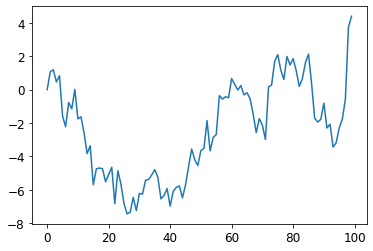

In [79]:
# --- random walk --- #

n    = 100
x    = [0.]*n
x[0] = 0.

for i in range(1,n): 
  x[i] = np.random.normal(x[i-1], 1.0, 1)

plt.plot(x)
plt.show()

## Metropolis-Hastings algorithm

The Metropolis–Hastings algorithm is a Markov chain Monte Carlo (MCMC) method for obtaining a sequence of random samples from a probability distribution from which direct sampling is difficult. This sequence can be used to approximate the distribution (e.g. the distribution of parameters) or to compute an integral (e.g. an expected value).

It consists of picking an arbitrary starting value and then iteratively accepting or rejecting candidate samples.

More concretely, we wish to obtain our **posterior probability distribution** $p(\theta | d, \mathcal{M},I)$, however, we cannot sample from this distribution. Instead we will sample from the distribution $p(\theta,d|\mathcal{M},I)=\mathcal{L}(d|\theta,\mathcal{M}) \prod_{\theta_i \in \{u_m, K_N, u_d, Y_{nx}\}} \pi(\theta_i|\mathcal{M},I)$. Notice that we have all the components, the likelihood $\mathcal{L}(d|\theta,\mathcal{M})$ and the prior distributions which we predefine. 

The **Metropolis-Hastings algorithm**

We wish to obtain $p(\theta | d, \mathcal{M},I)$ having $p(\theta,d|\mathcal{M},I)$ where $p(\theta,d|\mathcal{M},I) \propto p(\theta | d, \mathcal{M},I)$. 

First, we choose a probability density function $q(\cdot|\cdot)$, see *Note 1)* for more details. Then, we conduct the M-H routine:

1.- Select initial value $\theta^{(0)}$

2.- For $i=1,\dots T$ repeat:

2a) Draw a candidate $\theta^{*} \sim q(\theta^{*}|\theta^{(i-1)})$

2b) compute ration $\alpha=\frac{p(\theta^*,d|\mathcal{M},I)/q(\theta^{*}|\theta^{(i-1)})}{p(\theta^{(i-1)},d|\mathcal{M},I)/q(\theta^{(i-1)}|\theta^{*})}=\frac{p(\theta^*,d|\mathcal{M},I)q(\theta^{(i-1)}|\theta^{*})}{p(\theta^{(i-1)},d|\mathcal{M},I)q(\theta^{*}|\theta^{(i-1)})}$

2c) Accept or reject candiate $\theta^{*}$

2ci) $\alpha \geq 1$ accept $\theta^*$ and set $\theta^{(i)}:=\theta^*$ 

2cii) $0 \leq \alpha \leq 1$ accept $\theta^*$ (set $\theta^{(i)}:=\theta^*$) with probabiliy $\alpha$

2ciii) Else, reject (set $\theta^{(i)}:=\theta^{(i-1)}$), which happens with probabiliy $1-\alpha$

This will create an MCMC that follows the distribution $p(\theta | d, \mathcal{M},I)$.


*Note 1)* $q(\cdot|\cdot)$ is a probability density $q(x|y)$ that suggests a candidate for the next sample value $x$, given the previous sample value $y$. This is the transition function for the MCMC, and should *therefore be carefully chosen*.

*Note 2)* A good heuristic is to have an acceptance rate of 25%-50%

*Note 3)* b) and c) act as a correction since the proposal distribution $p(\theta,d|\mathcal{M},I)$ is not the target distribution $p(\theta | d, \mathcal{M},I)$. At each step in the chain, we draw a candidate and decide whether to move the chain there or to remain where we are. If the proposed move to the candidate is advantageous, meaning if $\alpha$ is greater than 1, we will move there for sure. If it is not advantageous, we might still move there, but only with probability $\alpha$.

*Note 4)* if the distribution $q(\cdot|\cdot)$ is symmetric around its mean, then, $q(\theta^{(i-1)}|\theta^{*})=q(\theta^{*}|\theta^{(i-1)})$ and hence $\alpha=\frac{p(\theta^*,d|\mathcal{M},I)}{p(\theta^{(i-1)},d|\mathcal{M},I)}$ which is very simple to compute. This is called **random walk Metropolis-Hastings**.


## 1D random walk M-H algorithm example

We will fix all parameters except one from the example above

In [80]:
################################
# 1D random walk MH algorithm  # 
################################


###########################
# q distribution sampler  # 
###########################

def qSample(theta_i, samples_n=1):
    '''
    returns a sample of q given a previous that_i
    '''
    return np.random.normal(theta_i, 0.01*0.4, samples_n)

#############################
# gDistribution evaluation  # 
#############################

def gDistribution(thata_eval, prior_dist, NegLogLike):
    '''
    evaluates the g distribution using the prior and the likelohood
    '''
    NLL_g   = NegLogLike(thata_eval)
    prior_g = np.log(prior_dist.pdf(thata_eval))

    return prior_g - NLL_g

##############################
# Negative LogLikelohood 1D  # 
##############################

def NLL_1D(theta, x0=x0, steps_=steps_, tf=tf, xobs=xobs, Qmat=Qmat):
    theta_dic = {'u_m' : 0.0923*0.62, 'K_N' : 393.10, 'u_d' : theta, 
                 'Y_nx' : 504.49}  
    m         = ModelIntegration(theta_dic)
    xt, _     = m.simulation(steps_, tf, x0) 
    x_error   = (xobs-xt)
    nll       = sum(x_error.T[i]@Qmat@x_error.T[i] for i in range(x_error.shape[1]))

    return nll

#####################
# M-H 1D algorithm  # 
#####################

def MH_1D(n_iter, theta_0, qSampler, NegLogLike, gDistribution):

    # initializing
    priot_dist = scipy.stats.norm(0.02, 0.01*0.2)
    theta_l    = np.zeros(n_iter)
    theta_ls   = np.zeros(n_iter)
    accept_r   = 0                                              # to compute acceptance ratio 
    theta_i    = theta_0
    lg_i       = gDistribution(theta_i, priot_dist, NegLogLike) # log g probability

    # main MCMC loop
    for iter_i in range(n_iter):
        theta_star       = qSample(theta_i, samples_n=1) # new candidate
        lg_s             = gDistribution(theta_star, priot_dist, NegLogLike) # log g probability of candidate
        lalpha           = lg_s - lg_i # logarithmic likelihood of alpha
        lalpha           = np.exp(lalpha)
        theta_ls[iter_i] = theta_star

        # accept/reject candidate
        random_var_u = np.random.uniform(0,1,1)
        if random_var_u < lalpha:
            theta_i   = theta_star
            accept_r += 1
            lg_i      = lg_s

        theta_l[iter_i] = theta_i

    return theta_l, theta_ls, accept_r/n_iter

    

C:\Users\wangh\AppData\Local\Temp\ipykernel_17636\2570734968.py:39: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  return np.array([dev_Cx, dev_Cn],dtype='float64')


accept ratio =  0.48


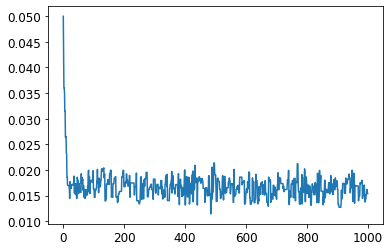

In [81]:
theta_l, theta_ls, accept_r =  MH_1D(1000, 0.05, qSample, NLL_1D, gDistribution)

print('accept ratio = ',accept_r)
plt.plot(theta_l)
plt.show()

### Stationary distribution

Notice that after a few iterations, our M-H algorithm seems to be converging to some probability distribution. This is calles the **stationary distribution**, and it is the distribution $p(\theta | d, \mathcal{M},I)$ we were after. The part before this is called the *burnout phase*, and when we plot the distribution, we must get rid of this, as this is the part of the MCMC moving towards the desired distribution. 

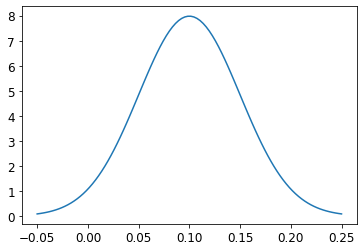

In [82]:
#########################################
# plotting the stationary distribution  # 
#########################################
mu = 0.1
sigma = 0.05
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, scipy.stats.norm.pdf(x, mu, sigma))
# theta_stationary = theta_l[0] # notice we get rid of the "burnout phase"
# plt.hist(theta_stationary, bins='auto')
plt.show()

In [83]:
theta_l[0]

0.05

In [84]:
prior_dist_l = [scipy.stats.norm(0.1, 0.05), scipy.stats.norm(500., 300.), 
                scipy.stats.norm(0.02, 0.01*0.2), scipy.stats.norm(300., 150.)]

## Multiple parameter sampling (Gibbs sampling)

One option is to perform Metropolis Hastings by sampling candidates for all the parameters at once. And accepting or rejecting all of those candidates together. While this is possible, it can get complicated. Another simpler option is, to sample the parameters one at a time.

Assume we have two parameters $\theta_1,\theta_2$, we have $p(\theta_1,\theta_2,d|\mathcal{M},I)$ and we wish to compute the posterior distribution $p(\theta_1,\theta_2 | d, \mathcal{M},I)$. 


The idea of Gibbs sampling is that we can update multiple parameters by sampling just one parameter at a time and cycling through all parameters and then repeating. This also produces a stationary Markov chain, whose stationary distribution is the target posterior distribution.

Let us understand why this works. For our two parameter example, we wish to computer $p(\theta_1,\theta_2 | d, \mathcal{M},I)$, but we only have access to some distribution $g(\theta_1,\theta_2)$ also function of $\theta_1,\theta_2$ which is proportional, that is:
$$g(\theta_1,\theta_2) \propto p(\theta_1,\theta_2 | d, \mathcal{M},I)$$

From the chain rule of probability we know that:

$$p(\theta_1,\theta_2 | d, \mathcal{M},I)=p(\theta_1|\theta_2, d, \mathcal{M},I)p(\theta_2|d, \mathcal{M},I)$$

Because the second term $p(\theta_2|d, \mathcal{M},I)$ is nor a function of $\theta_1$, and $g(\theta_1,\theta_2) \propto p(\theta_1,\theta_2 | d, \mathcal{M},I)$, then with respect to $\theta_1$:

$$p(\theta_1|\theta_2, d, \mathcal{M},I) \propto p(\theta_1,\theta_2| d, \mathcal{M},I) \propto g(\theta_1,\theta_2)$$

and with respect to $\theta_2$:

$$p(\theta_2|\theta_1, d, \mathcal{M},I) \propto p(\theta_1,\theta_2| d, \mathcal{M},I) \propto g(\theta_1,\theta_2)$$

Notice that the first term on both expressions above are the full posterior distributions for each parameter, as if we already knew the other parameter's value. This idea is used for **Gibbs sampling**, such that we can update multiple parameters by sampling just one parameter at a time and cycling through all parameters and then repeating. Therefore, to perform the update for one particular parameter we substitute in the current values of all the other parameters. 



### Multiple parameter Metropolis-Hastings algorithm by Gibbs sampling

The **Metropolis-Hastings algorithm Gibbs sampling**

We wish to obtain $p(\theta_1,\dots, \theta_{n_p} | d, \mathcal{M},I)$ having $p(\theta_1,\dots, \theta_{n_p},d | \mathcal{M},I)$ where $n_p$ is the number of parameters.



First, we choose a probability density function $q_j(\cdot|\cdot)$ for each parameter $j \in {1,\dots,n_p}$

Then, we conduct the M-H routine with Gibbs sampling:

1.   Select initial value $\theta_1^{(0)},\dots,\theta_{n_p}^{(0)}$
2.   For $i=1,\dots T$ repeat:
    * For $j=1,\dots n_p$ repeat: 
        * a$_0$) $\Theta^{(i-1)}_j=\theta_1^{(i)},\dots,\theta_{j-1}^{(i)},\theta_j^{(i-1)},\dots\theta_{n_p}^{(i-1)}$     
        * a) Draw a candidate $\theta_j^{*} \sim q_j(\theta_j^{*}|\Theta^{(i-1)}_j)$
        * b) compute ration $\alpha=\frac{p(\theta_j^*,d|\theta_1^{(i)},\dots,\theta_{n_p}^{(i-1)},\mathcal{M},I)/q(\theta_j^{*}|\Theta^{(i-1)}_j)}{p(\theta^{(i-1)},d|\theta_1^{(i)},\dots,\theta_{n_p}^{(i-1)},\mathcal{M},I)/q(\Theta^{(i-1)}_j|\theta^{*})}=\frac{p(\theta_j^*,d|\theta_1^{(i)},\dots,\theta_{n_p}^{(i-1)},\mathcal{M},I)q(\Theta^{(i-1)}_j|\theta^{*}_j)}{p(\theta_j^*,d|\theta_1^{(i)},\dots,\theta_{n_p}^{(i-1)},\mathcal{M},I)q(\theta_j^{*}|\Theta^{(i-1)}_j)}$
        * c) Accept or reject candiate $\theta_j^{*}$
            - $\alpha \geq 1$ accept $\theta_j^*$ and set $\theta_j^{(i)}:=\theta_j^*$ 
            - $0 \leq \alpha \leq 1$ accept $\theta_j^*$ (set $\theta_j^{(i)}:=\theta_j^*$) with probabiliy $\alpha$
            - Else, reject (set $\theta_j^{(i)}:=\theta_j^{(i-1)}$), which happens with probabiliy $1-\alpha$

This will create an MCMC that follows the distribution $p(\theta | d, \mathcal{M},I)$.

**Note:** further information and state-of-the-art Bayesia MCMC algorithms can be found in:



*   "emcee: The MCMC Hammer" by Daniel Foreman-Mackey, David W. Hogg, Dustin Lang and Jonathan Goodman
*   "dynesty: A Dynamic Nested Sampling Package for Estimating Bayesian Posteriors and Evidences" by Joshua S Speagle


## $n_p$-dimensional random walk M-H algorithm with Gibbs sampling example

In [85]:
################################################################
# Multiparameter random walk MH algorithm with Gibbs sampling  # 
################################################################


###########################
# q distribution sampler  # 
###########################

def qSample_multi(theta_i, std_sample, samples_n=1):
    '''
    returns a sample of q given a previous that_i
    '''
    return np.random.normal(theta_i, std_sample, samples_n)

#############################
# gDistribution evaluation  # 
#############################

def gDistribution(thata_eval, prior_dist_l, NegLogLike):
    '''
    evaluates the g distribution using the prior and the likelohood
    '''
    NLL_g   = NegLogLike(thata_eval)
    prior_g = 0.
    for i_prior in range(len(prior_dist_l)):
        prior_g += np.log(prior_dist_l[i_prior].pdf(thata_eval[i_prior]))
    return prior_g - NLL_g

#################################
# M-H Gibbs sampling algorithm  # 
#################################

def MH_Gibbs(n_iter, theta_0, qSampler, NegLogLike, gDistribution, prior_dist_l, std_sample_l):

    # initializing    
    n_theta      = theta_0.shape[0]
    theta_l      = np.zeros((n_theta, n_iter))
    theta_ls     = np.zeros((n_theta, n_iter))
    accept_r     = np.zeros(n_theta)         # to compute acceptance ratio 
    theta_i      = theta_0
    lg_i         = gDistribution(theta_i, prior_dist_l, NegLogLike) # log g probability

    # main MCMC loop
    for iter_i in range(n_iter):
        for theta_k in range(n_theta):
            theta_star          = np.copy(theta_i)
            theta_star[theta_k] = qSample_multi(theta_i[theta_k], std_sample_l[theta_k], samples_n=1) # new candidate
            lg_s                = gDistribution(theta_star, prior_dist_l, NegLogLike) # log g probability of candidate
            lalpha              = lg_s - lg_i # logarithmic likelihood of alpha
            lalpha              = np.exp(lalpha)
            theta_ls[:, iter_i] = theta_star

            # accept/reject candidate
            random_var_u = np.random.uniform(0,1,1)
            if random_var_u < lalpha:
                theta_i            = np.copy(theta_star)
                accept_r[theta_k] += 1
                lg_i               = lg_s

            theta_l[:, iter_i] = theta_i

    return theta_l, theta_ls, accept_r/n_iter

    

In [86]:
# prior distributions of parameters
prior_dist_l = [scipy.stats.norm(0.1, 0.05), scipy.stats.norm(500., 300.), 
                scipy.stats.norm(0.02, 0.01*0.2), scipy.stats.norm(300., 150.)]
# "exploration" term for the q function
std_sample_l = [0.05, 300., 0.01*0.2, 150.] # set to the std value of the prior, just as coincidence
theta_0      = np.array([0.5, 1000., 0.05, 800.])
total_iter   = 10000

theta_l, theta_ls, accept_r =  MH_Gibbs(total_iter, theta_0,qSample_multi, NLL, gDistribution, prior_dist_l, std_sample_l)


c:\Users\wangh\env\lib\site-packages\scipy\integrate\_ode.py:1350: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
C:\Users\wangh\AppData\Local\Temp\ipykernel_17636\2570734968.py:36: RuntimeWarning: overflow encountered in double_scalars
  dev_Cx  = u_m * Cx * Cn/(Cn+K_N) - u_d*Cx**2
C:\Users\wangh\AppData\Local\Temp\ipykernel_17636\2570734968.py:36: RuntimeWarning: invalid value encountered in double_scalars
  dev_Cx  = u_m * Cx * Cn/(Cn+K_N) - u_d*Cx**2
C:\Users\wangh\AppData\Local\Temp\ipykernel_17636\2570734968.py:37: RuntimeWarning: invalid value encountered in double_scalars
  dev_Cn  = - Y_nx * u_m * Cx * Cn/(Cn+K_N) + FCn
C:\Users\wangh\AppData\Local\Temp\ipykernel_17636\2570734968.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  dev_Cx  = u_m * Cx * Cn/(Cn+K_N) - u_d*Cx**2
C:\Users\wangh\AppData\Local\Temp\ipykernel_17636\2570734968.py:37: RuntimeWarning: divide by ze

In [87]:
param_name = ["$u_{m}$","$K_{N}$","$u_{d}$","$Y_{N/x}$"]

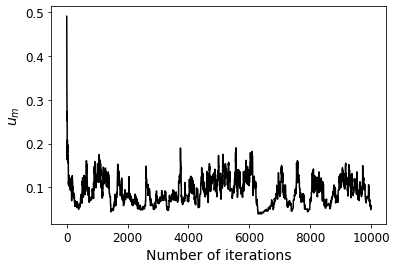

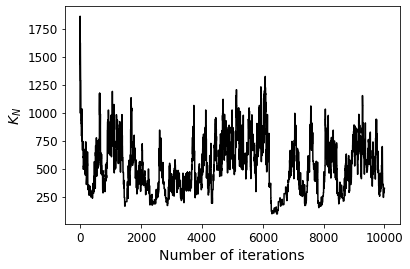

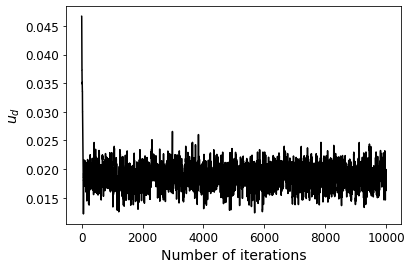

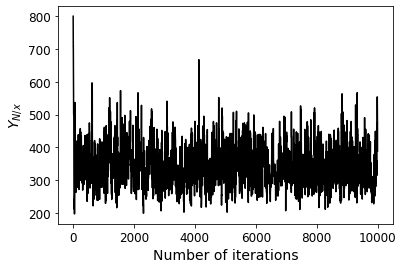

In [88]:
for p_ii in range(theta_0.shape[0]):
    plt.plot(theta_l[p_ii,:],color = 'black')
    plt.ylabel(param_name[p_ii],fontsize=14)
    plt.xlabel('Number of iterations',fontsize=14)
    plt.savefig(str(p_ii)+'.jpg',dpi = 480)
    plt.show()

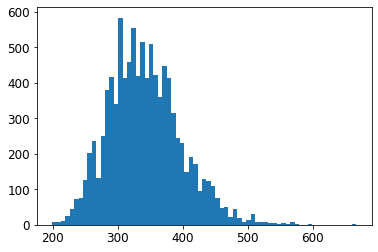

In [89]:
theta_stationary = theta_l[3,50:] # notice we get rid of the "burnout phase"
plt.hist(theta_stationary, bins='auto')
plt.show()

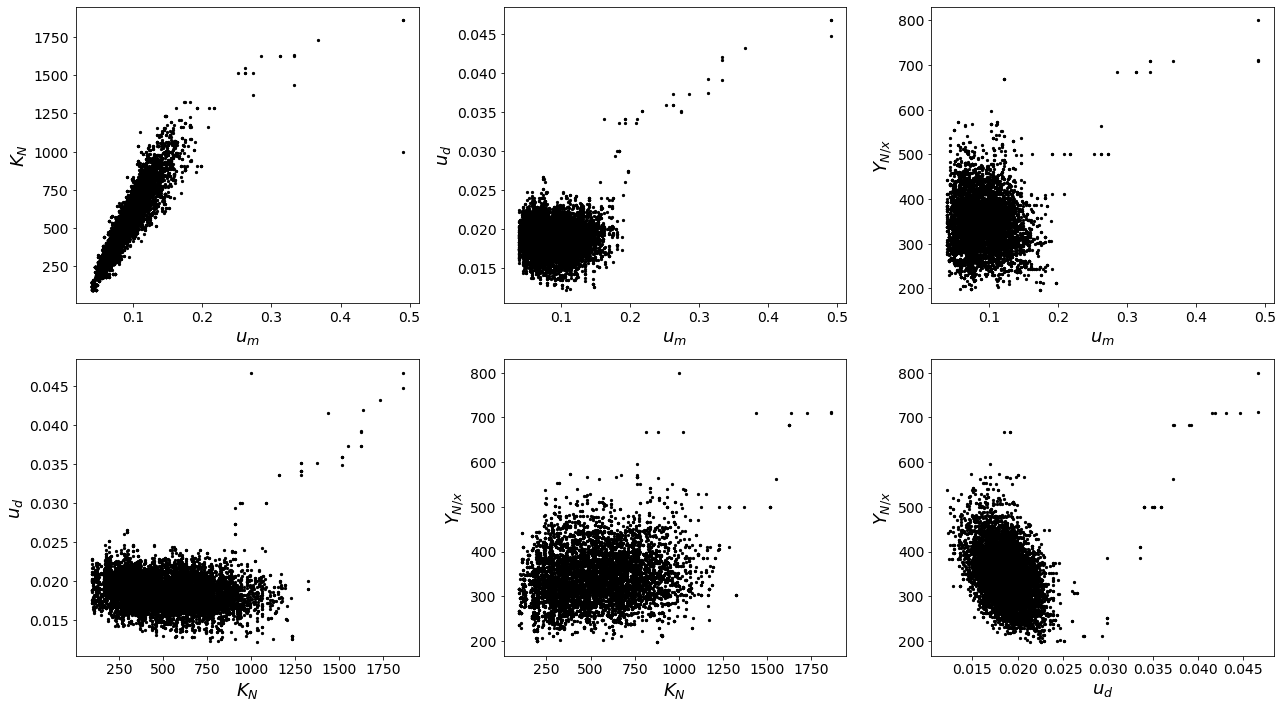

In [90]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(18, 10)

for i in range(3):
    k = 0
    for j in range(i+1,4):

        if i == 2:
            axs[1,2].scatter(theta_l[i,:], theta_l[j,:], s=5, color='black')
            # axs[1,2].set_title(param_name[i]+' vs '+param_name[j], fontsize=18)
            axs[1,2].tick_params(axis='both', which='major', labelsize=14)
            axs[1,2].set_xlabel(param_name[i], fontsize=18)
            axs[1,2].set_ylabel(param_name[j], fontsize=18)
        else:
            axs[i,k].scatter(theta_l[i,:], theta_l[j,:], s=5, color='black')
            # axs[i,k].set_title(param_name[i]+' vs '+param_name[j], fontsize=18)
            axs[i,k].tick_params(axis='both', which='major', labelsize=14)
            axs[i,k].set_xlabel(param_name[i], fontsize=18)
            axs[i,k].set_ylabel(param_name[j], fontsize=18)
        k = k+1



# for p_ii in range(theta_0.shape[0]):
#     for p_jj in range(p_ii,theta_0.shape[0]):

#         axs[p_ii, p_jj].scatter(theta_l[p_ii,:], theta_l[p_jj,:], s=5, color='black')
#         axs[p_ii, p_jj].set_title(param_l[p_ii]+' vs '+param_l[p_jj], fontsize=10)
#         #plt.plot(theta_l[p_ii,:])
fig.tight_layout()
plt.savefig('bayesian.jpg',dpi = 480)

plt.show()



1.   E. A. del Rio-Chanona, P. Dechatiwongse, D. Zhang, G.C. Maitland, K. Hellgardt, H. Arellano-Garcia, V.S. Vassiliadis, **Optimal operation strategy for biohydrogen production**, Ind. Eng. Chem. Res., vol. 54 (24), pp. 6334–6343, 2015
2.   A. Bernardi, L. Gomoescu, J. Wang, C. C. Pantelides, D. Chadwick, B. Chachuat, **Kinetic model discrimination for methanol and DME synthesis using Bayesian estimation**, 2019
3.   Richard McElreath. **Statistical rethinking: A Bayesian course with examples in R and Stan**,
volume 122. CRC Press, 2016.


